In [1]:
import sys
sys.path.append('/home/yujiehe/anisotropy-flamingo')
import tools.clusterfit as cf
import numpy as np
import pandas as pd

## dipole H0 error

In [2]:
A_alls = [1.542, 1.099, 1.094]
p = [1/2, 1/2, 2/5]
H0_all = 68.1 #flamingo fiducial value

# Values
H0_sigma = np.empty((3, 8100))
H0 = np.empty((3, 8100))

i = 0
for relation in ['LX-T', 'YSZ-T', 'M-T']:
    best_fit_file = f'/data1/yujiehe/data/fits/testrun/lightcone1/scan_best_fit_{relation}_θ60.csv'
    best_fit = pd.read_csv(best_fit_file)

    A = best_fit['A'].values
    H0[i] = H0_all * (A/A_alls[i])**p[i]

    best_fit['H0'] = H0[i]
    for j in range(len(best_fit)):
        glon = best_fit['Glon'][j]
        glat = best_fit['Glat'][j]
        if glat < 0 or glat == 90.0: # only need to do half of the directions
            continue
        dp_glon = glon + 180 if glon < 0 else glon - 180 # zero to - 180
        dp_glat = - glat

        H1 = best_fit.loc[j, 'H0'] # query directly by index to save computation, this gives a np.float64 number directly so no need for conversion
        dp_mask = (best_fit['Glon'] == dp_glon) & (best_fit['Glat'] == dp_glat)
        H2 = best_fit.loc[dp_mask, 'H0']
        H2 = float(H2.iloc[0])
        
        best_fit.loc[j, 'H0'] = (H1 - H2) / 2 + H0_all
        best_fit.loc[dp_mask, 'H0'] = (H2 - H1) / 2 + H0_all

    H0[i] = best_fit['H0'].values
    H0_sigma[i] = best_fit['sigma'].values
    
    i += 1

H0_ave = np.average(H0, axis=0, weights=1/H0_sigma**2)

/var/tmp/yujiehe/ipykernel_4120605/1343541020.py:39: RuntimeWarning: divide by zero encountered in divide
  H0_ave = np.average(H0, axis=0, weights=1/H0_sigma**2)
/data1/yujiehe/conda-env/halo/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.03159759403498071


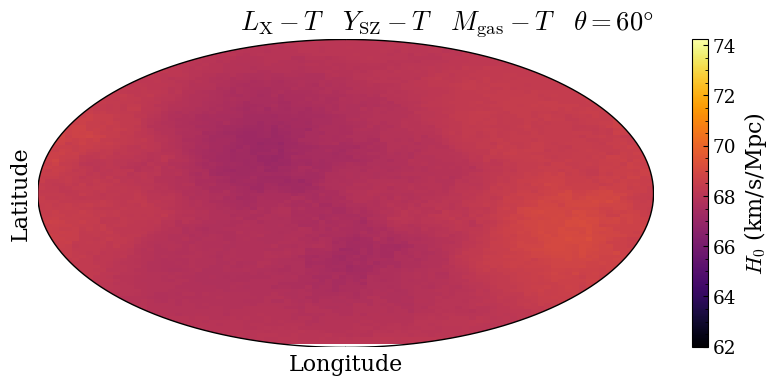

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./nice.mplstyle")
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10, 4))
m = Basemap(projection='hammer', lon_0=0)

# Coordinates
lon = np.linspace(-180, 180, 90)
lat = np.linspace(-90, 90, 90)
lons, lats = np.meshgrid(lon, lat)
x, y = m(lons, lats)

im = m.imshow(H0_ave.reshape(90, 90).T,  extent=[-180, 180, -90, 90], 
              vmin=0.91*H0_all, vmax=1.09*H0_all,
              cmap='inferno')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

var = (np.nanmax(H0_ave) - np.nanmin(H0_ave))/68.1
print(var)

plt.colorbar(im, label='$H_0$ (km/s/Mpc)')
plt.title('$L_\\mathrm{{X}}-T\\quad Y_\\mathrm{{SZ}}-T\\quad M_\\mathrm{{gas}}-T\\quad\\theta=60\\degree$', loc='right')
#plt.savefig('../data/plots/dipole_H0_map_for_talk_lc1.png', dpi=300, transparent=True)
plt.show()

# Some disscussion

In [4]:
np.nanmax(H0_ave), np.nanmin(H0_ave)ß

(69.17589807689109, 67.0241019231089)

In [9]:
(np.nanmax(H0_ave) - np.nanmin(H0_ave))/68.1

0.03159759403498071

In [5]:
np.nanargmax(H0_ave), np.nanargmin(H0_ave)

(7231, 3209)

In [6]:
best_fit.loc[2571, 'Glon'], best_fit.loc[6609, 'Glon']

(-68.0, 112.0)

In [7]:
best_fit.loc[2571, 'Glat'], best_fit.loc[6609, 'Glat']

(12.0, -12.0)

In [8]:
cf.angular_separation(-34, 24, 56, -24)

99.52248781407008

In [23]:
np.nanargmax(H0[0]), np.nanargmin(H0[0])

(591, 4629)

In [25]:
4629-591, 6609-2571

(4038, 4038)

## number of significance

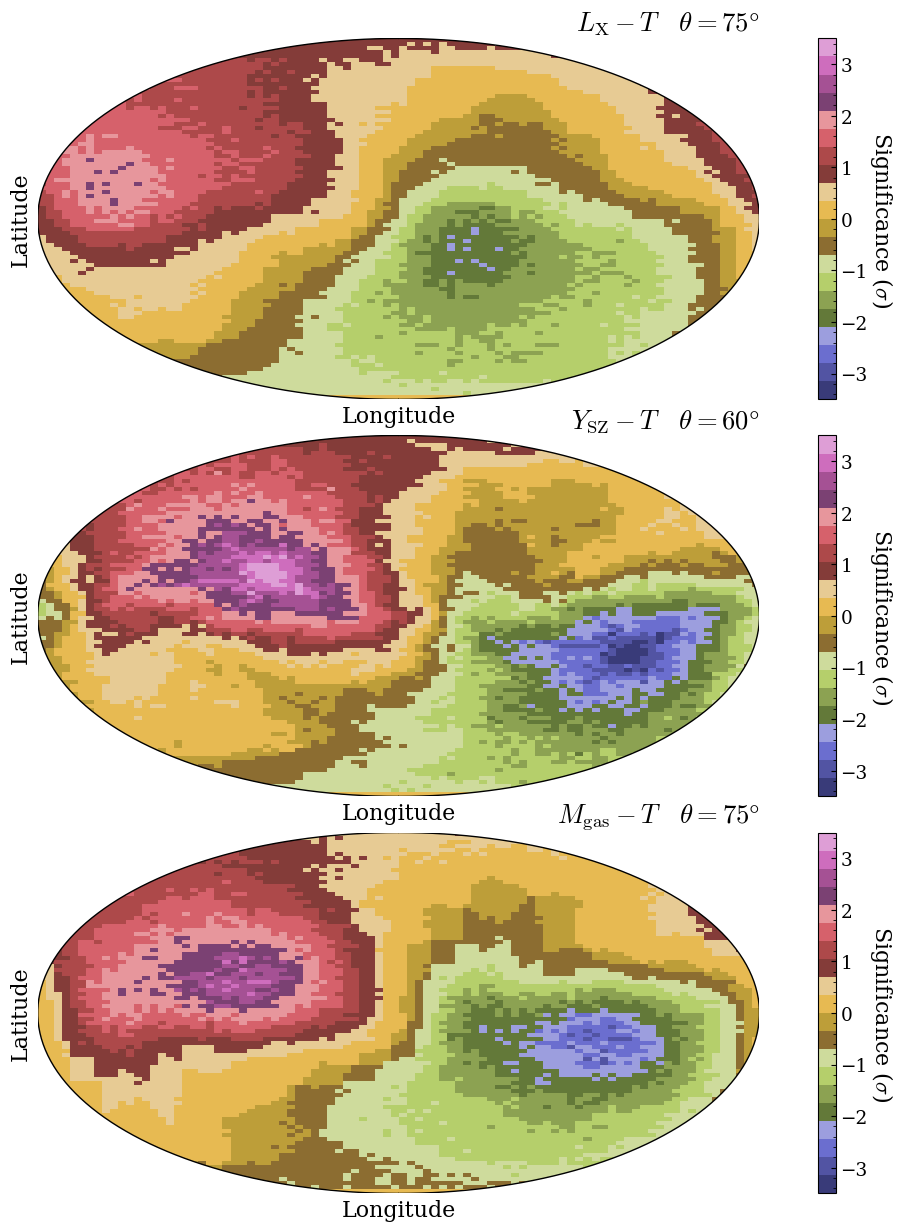

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.style.use("./nice.mplstyle")
import pandas as pd
import numpy as np

fig, ax = plt.subplots(3, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.1, wspace=0.05)

m = Basemap(projection='hammer', lon_0=0)

lon = np.linspace(-180, 180, 90)
lat = np.linspace(-90, 90, 90)
lons, lats = np.meshgrid(lon, lat)
x, y = m(lons, lats)


files = ['../data/fits/testrun/lightcone1/scan_best_fit_LX-T_θ75.csv', 
         '../data/fits/testrun/lightcone1/scan_best_fit_YSZ-T_θ60.csv',
         '../data/fits/testrun/lightcone1/scan_best_fit_M-T_θ75.csv', 
        ]

titles = ['$L_\\mathrm{{X}}-T\\quad\\theta=75\\degree$',
          '$Y_\\mathrm{{SZ}}-T\\quad\\theta=60\\degree$',
          '$M_\\mathrm{{gas}}-T\\quad\\theta=75\\degree$',
        ]


idx = 0
for subax in ax:
    subax.set_xlabel('Longitude')
    subax.set_ylabel('Latitude')
    # Load the data from the file
    df = pd.read_csv(files[idx])
    data = np.array(df['n_sigma']).reshape(90, 90).T
    # Display the data as an image; set the extent of the map
    im = m.imshow(data, extent=[-180, 180, -90, 90], cmap='tab20b', 
                    ax=subax, vmin=-3.5, vmax=3.5)

    cbar = plt.colorbar(im, ax=subax)
    cbar.set_label('Significance ($\\sigma$)', rotation=270, labelpad=20)
    subax.set_title(titles[idx], loc='right')
    idx += 1

plt.show()